In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile

import glob
from tqdm import tqdm
import librosa
from IPython.display import Audio

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential

from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [2]:
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [3]:
import glob,pickle
for file in tqdm(glob.glob(r'C:\Users\91954\SEAn\RAVDESS\\**\\*.wav')):
    file_name = os.path.basename(file)
    signal , rate = librosa.load(file, sr=16000)
    mask = envelope(signal,rate, 0.0005)
    wavfile.write(filename= r'C:\Users\91954\SEAn\Clean\\'+str(file_name), rate=rate,data=signal[mask])

100%|██████████| 1440/1440 [00:30<00:00, 47.65it/s]


In [4]:
import os
import pandas as pd

Clean = r'C:\Users\91954\SEAn\Clean'

# Create ravdess data frame.
clean_directory_list = os.listdir(Clean)

file_emotion = []
file_path = []
for actor_file in clean_directory_list:
    if actor_file.endswith('.wav'):
        part = actor_file.split('.')[0]
        part = part.split('-')
        # Check if part has at least 3 elements before accessing part[2]
        if len(part) >= 3:
            file_emotion.append(int(part[2]))
            file_path.append(os.path.join(Clean, actor_file))

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Clean_df = pd.concat([emotion_df, path_df], axis=1)

# Changing integers to actual emotions.
Clean_df['Emotions'].replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Clean_df.head()


,Emotions,Path
0,neutral,C:\Users\91954\SEAn\Clean\03-01-01-01-01-01-01...
1,neutral,C:\Users\91954\SEAn\Clean\03-01-01-01-01-01-02...
2,neutral,C:\Users\91954\SEAn\Clean\03-01-01-01-01-01-03...
3,neutral,C:\Users\91954\SEAn\Clean\03-01-01-01-01-01-04...
4,neutral,C:\Users\91954\SEAn\Clean\03-01-01-01-01-01-05...


In [5]:
data_path=Clean_df
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,C:\Users\91954\SEAn\Clean\03-01-01-01-01-01-01...
1,neutral,C:\Users\91954\SEAn\Clean\03-01-01-01-01-01-02...
2,neutral,C:\Users\91954\SEAn\Clean\03-01-01-01-01-01-03...
3,neutral,C:\Users\91954\SEAn\Clean\03-01-01-01-01-01-04...
4,neutral,C:\Users\91954\SEAn\Clean\03-01-01-01-01-01-05...


In [6]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

In [7]:
def extract_features(data, sample_rate):
    result = np.array([])
    
    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally
    
    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally
    
    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    # ZCR
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    return result


In [8]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result


In [9]:
X, Y = [], []

for path, emotion in zip(data_path.Path, data_path.Emotions):
    try:
        feature = get_features(path)
        for ele in feature:
            X.append(ele)
            # Appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
            Y.append(emotion)
    except Exception as e:
        print(f"Error processing file {path}: {e}")

Error processing file C:\Users\91954\SEAn\Clean\03-01-04-01-01-01-09.wav: module 'soundfile' has no attribute 'SoundFileRuntimeError'
Error processing file C:\Users\91954\SEAn\Clean\03-01-04-01-01-02-09.wav: module 'soundfile' has no attribute 'SoundFileRuntimeError'


In [10]:
len(X), len(Y), data_path.Path.shape

(4314, 4314, (1440,))

In [11]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,-518.992737,185.130753,-29.358130,29.616070,5.253566,3.108177,-18.896374,-0.919874,-40.728683,-3.885707,...,2.624859e-09,2.512421e-09,2.428969e-09,2.369180e-09,2.325788e-09,2.297917e-09,2.280506e-09,0.036385,0.005305,neutral
1,-434.313394,94.991475,19.540946,11.068312,11.985902,-1.270938,-7.254986,-13.884048,-22.407243,-11.997847,...,1.845179e-05,1.720861e-05,1.494778e-05,1.582597e-05,1.588924e-05,1.562899e-05,1.668243e-05,0.071306,0.005331,neutral
2,-568.399902,178.415253,-31.896523,28.503258,2.871634,-2.732339,-18.670496,-6.066448,-45.463253,3.485139,...,1.693707e-09,1.563646e-09,1.464447e-09,1.399622e-09,1.362916e-09,1.085743e-09,4.234986e-10,0.050008,0.002943,neutral
3,-484.873474,151.879562,-47.949074,18.851910,-25.641949,-0.594666,-15.072431,-14.307671,-10.783791,-3.619339,...,8.251591e-09,7.988178e-09,7.792050e-09,7.653663e-09,7.553677e-09,7.491272e-09,7.451711e-09,0.063561,0.007698,neutral
4,-438.133347,98.128240,-12.438224,-3.620978,-11.320782,-9.690924,-9.385655,-15.239522,-10.915218,-3.673301,...,5.820392e-06,5.371649e-06,6.329094e-06,6.062996e-06,6.007296e-06,5.415374e-06,5.438653e-06,0.086978,0.007704,neutral


In [12]:
# Assuming your data is stored in X and Y
X = Features.iloc[:, :-1].values
Y = Features['labels'].values

In [13]:
# One-hot encode the target variable
encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

In [14]:
# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [15]:
# Scaling the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


In [16]:
# Reshaping the input data for RNN
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))


In [17]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3451, 1, 162), (3451, 8), (863, 1, 162), (863, 8))

In [18]:
from keras.regularizers import l1, l2

# Define the deep RNN model with batch normalization and increased units
model_deep_rnn = Sequential()

# Adding first Simple RNN layer with batch normalization and L2 regularization
model_deep_rnn.add(SimpleRNN(units=128, activation='relu', return_sequences=True, input_shape=(None, x_train.shape[2]),
                              kernel_regularizer=l2(0.01)))
model_deep_rnn.add(BatchNormalization())

# Adding second Simple RNN layer with batch normalization and L2 regularization
model_deep_rnn.add(SimpleRNN(units=128, activation='relu', return_sequences=True,
                              kernel_regularizer=l2(0.01)))
model_deep_rnn.add(BatchNormalization())

# Adding third Simple RNN layer with batch normalization and L2 regularization
model_deep_rnn.add(SimpleRNN(units=128, activation='relu', return_sequences=True,
                              kernel_regularizer=l2(0.01)))
model_deep_rnn.add(BatchNormalization())

# Adding fourth Simple RNN layer with L2 regularization
model_deep_rnn.add(SimpleRNN(units=128, activation='relu', kernel_regularizer=l2(0.01)))

# Adding dropout for regularization
model_deep_rnn.add(Dropout(0.5))

# Adding output layer
model_deep_rnn.add(Dense(units=8, activation='softmax'))  # Assuming 8 classes for classification

# Compile the model
optimizer = Adam(lr=0.001)
model_deep_rnn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# Print the model summary
model_deep_rnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 128)         37248     
                                                                 
 batch_normalization (Batch  (None, None, 128)         512       
 Normalization)                                                  
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 128)         32896     
                                                                 
 batch_normalization_1 (Bat  (None, None, 128)         512       
 chNormalization)                                                
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 128)         32896     
                                                                 
 batch_normalization_2 (Bat  (None, None, 128)         5

In [19]:
# Define the ReduceLROnPlateau and EarlyStopping callbacks
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=1, patience=2, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Assuming x_train, y_train, x_test, and y_test are already defined and preprocessed
# Train the model
history_deeprnn = model_deep_rnn.fit(
    x_train, y_train,
    batch_size=64, epochs=50,
    validation_data=(x_test, y_test),
    callbacks=[rlrp, early_stopping]
)



Epoch 1/50
54/54 [==============================] - 5s 16ms/step - loss: 7.0128 - accuracy: 0.2651 - val_loss: 6.4878 - val_accuracy: 0.3951 - lr: 0.0010
Epoch 2/50
54/54 [==============================] - 0s 6ms/step - loss: 5.8646 - accuracy: 0.4193 - val_loss: 5.6804 - val_accuracy: 0.4751 - lr: 0.0010
Epoch 3/50
54/54 [==============================] - 0s 8ms/step - loss: 5.0487 - accuracy: 0.4935 - val_loss: 4.9476 - val_accuracy: 0.5110 - lr: 0.0010
Epoch 4/50
54/54 [==============================] - 0s 8ms/step - loss: 4.3142 - accuracy: 0.5706 - val_loss: 4.3217 - val_accuracy: 0.5272 - lr: 0.0010
Epoch 5/50
54/54 [==============================] - 0s 9ms/step - loss: 3.7655 - accuracy: 0.6010 - val_loss: 3.8069 - val_accuracy: 0.5330 - lr: 0.0010
Epoch 6/50
54/54 [==============================] - 0s 8ms/step - loss: 3.2433 - accuracy: 0.6514 - val_loss: 3.3705 - val_accuracy: 0.5597 - lr: 0.0010
Epoch 7/50
54/54 [==============================] - 0s 8ms/step - loss: 2.8402 - 

In [20]:
print("Accuracy of our model on test data : ", model_deep_rnn.evaluate(x_test, y_test)[1] * 100, "%")

27/27 [==============================] - 0s 3ms/step - loss: 0.8725 - accuracy: 0.8413
Accuracy of our model on test data :  84.12514328956604 %


In [21]:
train_accuracy = history_deeprnn.history['accuracy'][-1]
print("Accuracy on the training dataset:", train_accuracy)
test_accuracy = history_deeprnn.history['val_accuracy'][-1]
print("Accuracy on the test dataset:", test_accuracy)


Accuracy on the training dataset: 0.9965227246284485
Accuracy on the test dataset: 0.8412514328956604


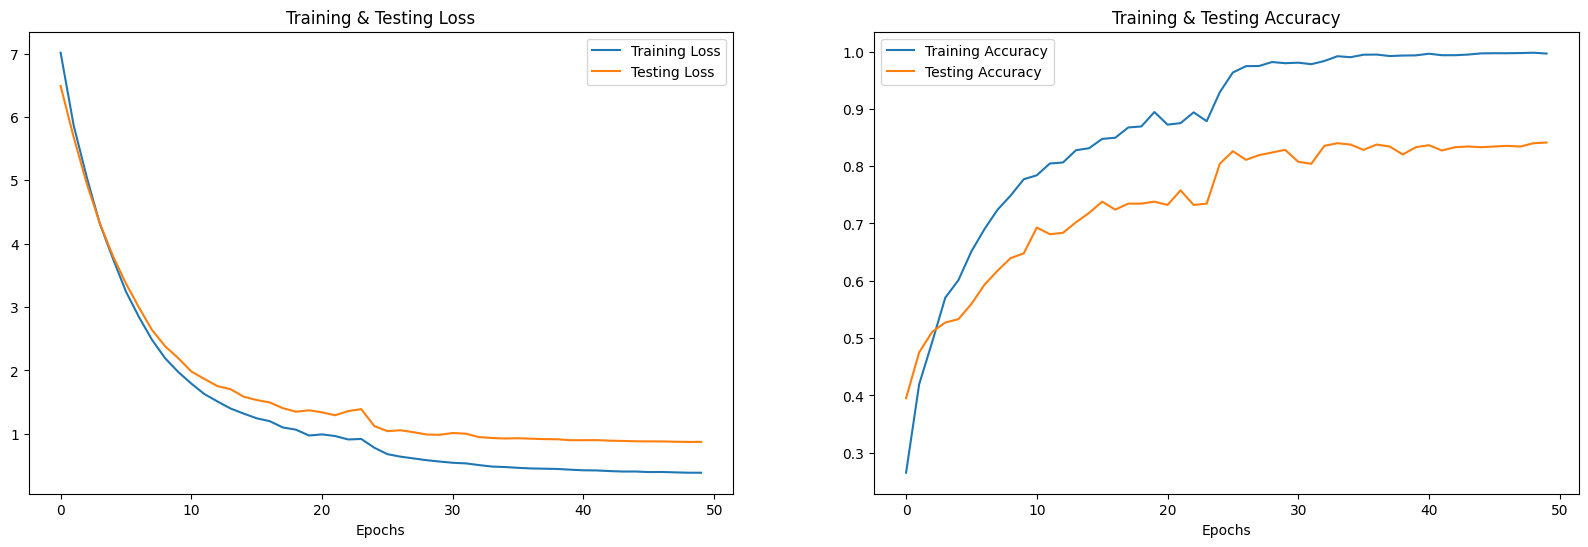

In [22]:
import matplotlib.pyplot as plt

# Get the actual number of epochs the model trained for
epochs = range(len(history_deeprnn.history['accuracy']))

fig, ax = plt.subplots(1, 2)

train_acc_rnn = history_deeprnn.history['accuracy']
train_loss_rnn = history_deeprnn.history['loss']
test_acc_rnn = history_deeprnn.history['val_accuracy']
test_loss_rnn = history_deeprnn.history['val_loss']

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss_rnn, label='Training Loss')
ax[0].plot(epochs, test_loss_rnn, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc_rnn, label='Training Accuracy')
ax[1].plot(epochs, test_acc_rnn, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.show()


In [23]:
# Predicting on test data
pred_test = model_deep_rnn.predict(x_test)

# Convert predicted probabilities to class labels
pred_test_labels = pred_test.argmax(axis=1)

# Inverse transform the predicted labels to original labels
y_pred = encoder.inverse_transform(pred_test)

# Inverse transform the true test labels to original labels
y_test_labels = encoder.inverse_transform(y_test)

# Evaluate model performance
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test_labels, y_pred))
#print(confusion_matrix(y_test_labels, y_pred))


27/27 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

       angry       0.91      0.76      0.83       110
        calm       0.89      0.93      0.91       117
     disgust       0.82      0.85      0.83       110
        fear       0.85      0.84      0.85       101
       happy       0.76      0.84      0.80       121
     neutral       0.89      0.71      0.79        68
         sad       0.80      0.84      0.82       116
    surprise       0.86      0.89      0.88       120

    accuracy                           0.84       863
   macro avg       0.85      0.83      0.84       863
weighted avg       0.84      0.84      0.84       863



In [24]:
# predicting on test data.
pred_test = model_deep_rnn.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

27/27 [==============================] - 0s 2ms/step


In [25]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,surprise,surprise
1,surprise,disgust
2,disgust,angry
3,happy,happy
4,sad,sad
5,angry,angry
6,surprise,surprise
7,angry,angry
8,calm,calm
9,surprise,surprise


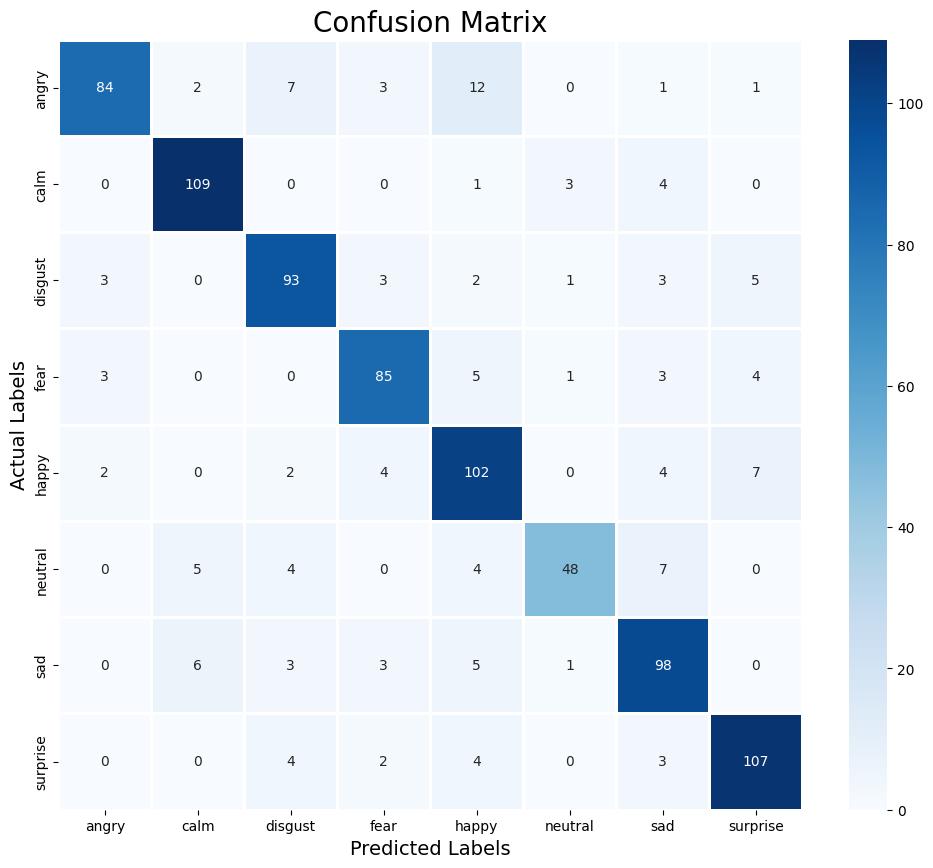

In [26]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [27]:
# Save the trained model
model.save('trained_model.h5')
print("Model saved successfully.")

NameError: name 'model' is not defined

In [28]:
# Save the trained model in native Keras format
model_deep_rnn.save('trained_model_rnn.keras')
print("Model saved successfully.")



Model saved successfully.
